In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
plt.style.use('ggplot')

In [22]:
control = pd.read_csv('control_data.csv')
exper = pd.read_csv('experiment_data.csv')

In [23]:
control_ep = control.dropna()
exper_ep = exper.dropna()

In [24]:
control_ep['click_through'] = control_ep['Clicks'] / control_ep['Pageviews']
exper_ep['click_through'] = exper_ep['Clicks'] / exper_ep['Pageviews']

<ipython-input-24-bf9a39e53d92>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_ep['click_through'] = control_ep['Clicks'] / control_ep['Pageviews']
<ipython-input-24-bf9a39e53d92>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exper_ep['click_through'] = exper_ep['Clicks'] / exper_ep['Pageviews']


In [25]:
control_ep['Enrollment_rate'] = control_ep['Enrollments'] / control_ep['Clicks']
control_ep['payment_rate'] = control_ep['Payments'] / control_ep['Clicks']
exper_ep['Enrollment_rate'] = exper_ep['Enrollments'] / exper_ep['Clicks']
exper_ep['payment_rate'] = exper_ep['Payments'] / exper_ep['Clicks']

<ipython-input-25-dc27e09d9d92>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_ep['Enrollment_rate'] = control_ep['Enrollments'] / control_ep['Clicks']
<ipython-input-25-dc27e09d9d92>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_ep['payment_rate'] = control_ep['Payments'] / control_ep['Clicks']
<ipython-input-25-dc27e09d9d92>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

First Step:

Plot the Binomial Distribution for each control and experiment and compare the overlap between the two peaks visually.  Trying to find "true conversion rate"

Number of trials= "Clicks"
Number of successes= "Enrollments"

We'll find conversion rate for each site (sum of conversions) and plot the distribution of likely conversions

In [26]:
control_clicks=sum(control_ep['Clicks'])
control_enroll=sum(control_ep['Enrollments'])
exper_clicks=sum(exper_ep['Clicks'])
exper_enroll=sum(exper_ep['Enrollments'])

In [27]:
control_pay=sum(control_ep['Payments'])
exper_pay=sum(exper_ep['Payments'])

In [28]:
control_clicks*control_enroll/control_clicks

3785.0

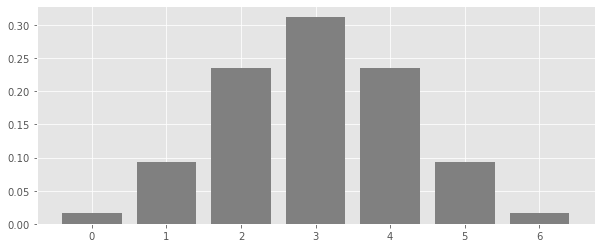

In [29]:
binomial = stats.binom(n=6, p=0.5)

fig, ax = plt.subplots(1, figsize=(10, 4))
_ = ax.bar(range(7), [binomial.pmf(i) for i in range(7)], color="grey")

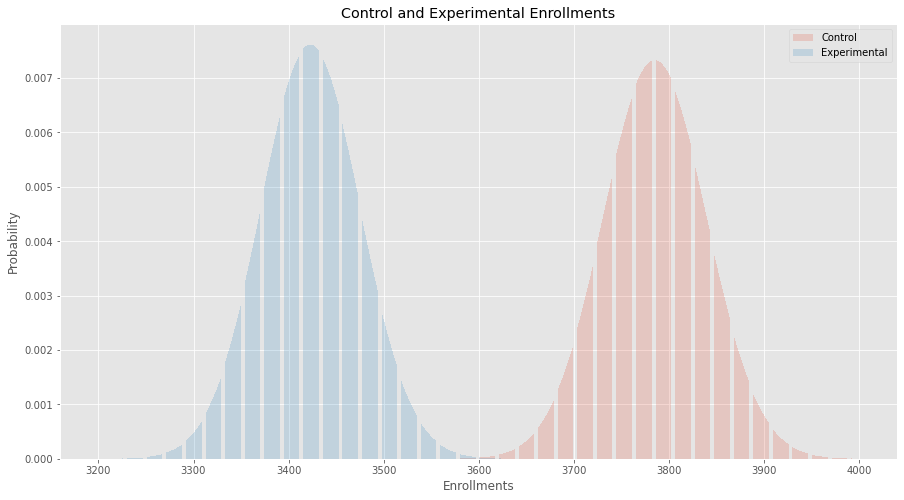

In [30]:
fig, ax = plt.subplots(1, figsize=(15,8))
x=np.arange(3200, 4000, 1)
control_binom=[stats.binom(n=control_clicks, p=(control_enroll/control_clicks)).pmf(i) for i in x]
exper_binom=[stats.binom(n=exper_clicks, p=(exper_enroll/exper_clicks)).pmf(i) for i in x]
ax.bar(x, control_binom, alpha=0.2, label="Control")
ax.bar(x, exper_binom, alpha=0.2, label="Experimental")
ax.set_title('Control and Experimental Enrollments')
ax.set_xlabel('Enrollments')
ax.set_ylabel('Probability')
ax.legend()
plt.savefig('Enrollment-control_exp')

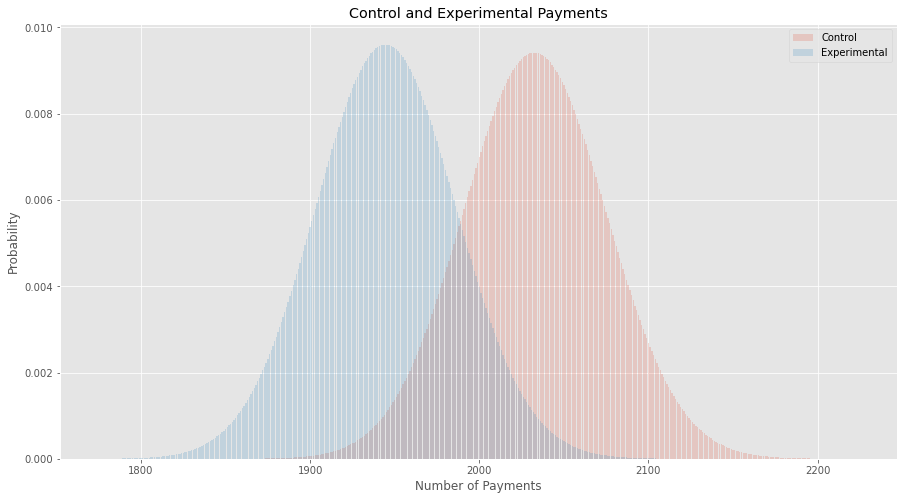

In [31]:
fig, ax = plt.subplots(1, figsize=(15,8))
x=np.arange(1775, 2225, 1)
control_binom=[stats.binom(n=control_clicks, p=(control_pay/control_clicks)).pmf(i) for i in x]
exper_binom=[stats.binom(n=exper_clicks, p=(exper_pay/exper_clicks)).pmf(i) for i in x]
ax.bar(x, control_binom, alpha=0.2, label="Control")
ax.bar(x, exper_binom, alpha=0.2, label="Experimental")
ax.set_title('Control and Experimental Payments')
ax.set_xlabel('Number of Payments')
ax.set_ylabel('Probability')
ax.legend()
plt.savefig('Payment-control_exp')

From these graphs it looks like it is likely that the enrollments vary, unlikely that payments vary.  A difference test will be performed to see if the difference between control and experimental groups vary in a statistically significant way.

In [32]:
def ttest_act(s1_act, s2_act, s1_cnt, s2_cnt, a=0.05):
    shared_freq=(s1_act+s2_act)/(s1_cnt+s2_cnt)
    shared_var=(s1_cnt+s2_cnt)*shared_freq*(1-shared_freq)/(s1_cnt*s2_cnt)
    difference_in_proportions = stats.norm(0, np.sqrt(shared_var))
    threshold=difference_in_proportions.ppf(1-a)
    diff=s1_act/s1_cnt-s2_act/s2_cnt
    p_val=1-difference_in_proportions.cdf(diff)
    print('threshold={:2.3f}, diff={:2.3f}, p_value={:2.3f}'.format(threshold, diff, p_val))
    return difference_in_proportions

In [33]:
ttest_act(control_enroll, exper_enroll, control_clicks, exper_clicks)

threshold=0.007, diff=0.021, p_value=0.000


In [34]:
ttest_act(control_pay, exper_pay, control_clicks, exper_clicks)

threshold=0.006, diff=0.005, p_value=0.078


graphing 

threshold=0.007, diff=0.021, p_value=0.000


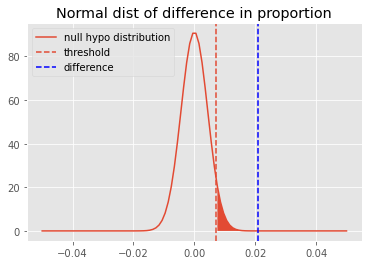

In [37]:
fig, ax = plt.subplots(1)
x = np.linspace(-.05,.05,100)
y = ttest_act(control_enroll, exper_enroll, control_clicks, exper_clicks).pdf(x)
ax.plot(x,y, label="null hypo distribution")
ax.set_title('Normal dist of difference in proportion')
ax.axvline(0.007,ls='--', label='threshold')
ax.fill_between(x,0,y,x> .007 )
#ax.fill_between(x, 0, difference_in_proportions.pdf(x), x>threshold, color = 'blue')
ax.axvline(.021,color='blue',ls="--", label='difference')
ax.legend()


the null hypothis is the curve. and we are saying the minimum overlap has to be at .007 

" threshold is the ppf at 1-alpha or the right side tail. this gives us the x value that you need to get a differnce value higher to regect the null. if not you fail to reject the null. "
"" differene is the 


a / b testing 


many different ways to do it. 

first way is to do it like I did for my grit study. I had two classes lefy and righy and I had a continous target, the grit score they got. I bootstraped becuase the distribution was not normal and then got the means for each re-sample. I then found the differnce of those means for the two classes and set up a hypothisis test. Making the diffence in means = 0 as the null and not equal to zero as the alt. I then found the 95% confidince interval and found that since 0 was in the 95% confidnce we fail to reject the null hypthisis that there is no diffence in means. 

Second way I learned is using bayes and monte carlo simulation. I separated the two classes again. I caculated the parameters for the beta distribution for the two classes. Then I ran a monte carlo simulation using .rvs() in order to draw a large number of random samples from each distribution created above. I can then count the number of times lefty samples are greater than righties. I can do this 10,000 times within seconds with a computer. And finally compare the amount of times the points from one distribution is greater than the other. You end with a statment like " it is ___ % likely that a sample of lefties score higher than a smaple of righties.


Third way is when you have lets say clicks and payments from a website. And you want to see which website leads to the most payments that is a binomial distribution. You can use diffence in proportions to make a normal distribution with the proprtion variance and then you can calucalte the ppf of (1 - significance level) to get the threshold you need to pass and then you can calcualte the diffence and p value too. The p value come from the (1 - cdf(differnce)) of the normal diffence in proportions distribution. This means simlpy that if the difference is to the right of the threshold, your p value is likey to be small and signficant. If the difference is to the left of the threshold, probably the p value is to big to be siginficant. 

why can you calculate the 95% confidnce interval in this ? 



threshold=0.006, diff=0.005, p_value=0.078


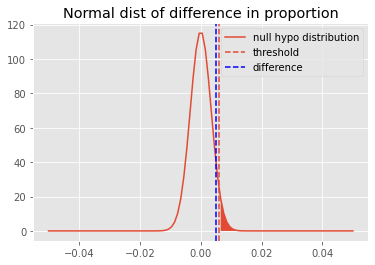

In [38]:
fig, ax = plt.subplots(1)
x = np.linspace(-.05,.05,100)
y = ttest_act(control_pay, exper_pay, control_clicks, exper_clicks).pdf(x)
ax.plot(x,y, label="null hypo distribution")
ax.set_title('Normal dist of difference in proportion')
ax.axvline(0.006,ls='--', label='threshold')
ax.fill_between(x,0,y,x> .006 )
#ax.fill_between(x, 0, difference_in_proportions.pdf(x), x>threshold, color = 'blue')
ax.axvline(.005,color='blue',ls="--", label='difference')
ax.legend()


Since the differnce has not passed the threshold you are not suprised enough that 

start with why?

methodoligy:

We want to see if experimnetal site is better than curent site. 
we do that by checking paymetns and clicks 


